In [1]:
from torch.distributions.beta import Beta
from mutect3 import tensors, train, networks, data
from mutect3 import normal_artifact as na
import torch.utils.data

%matplotlib inline

In [2]:
# load table files produced by GATK, parse and generate data, and pickle data
PICKLE_DIR = '/Users/davidben/broad/mutect3/pickles/'
NORMAL_ARTIFACT_DIR = '/Users/davidben/broad/mutect3/normal_artifact/'


DREAMS = ['dream1', 'dream2' , 'dream3', 'dream4']
tumor_samples = ['synthetic.challenge.set1.tumor','background.synth.challenge2.snvs.svs.tumorbackground','IS3.snv.indel.sv','synthetic.challenge.set4.tumour']
normal_samples = ['synthetic.challenge.set1.normal','synthetic.challenge.set2.normal','G15512.prenormal.sorted','synthetic.challenge.set4.normal']

DREAM_1_PAIR, DREAM_2_PAIR, DREAM_3_PAIR, DREAM_4_PAIR = (PICKLE_DIR + dream + '-pair-train.pickle' for dream in DREAMS)
DREAM_1_TEST, DREAM_2_TEST, DREAM_3_TEST, DREAM_4_TEST = (PICKLE_DIR + dream + '-test.pickle' for dream in DREAMS)


# just dream 1 for speed
#DREAMS = ['dream1']
#tumor_samples = ['synthetic.challenge.set1.tumor']
#normal_samples = ['synthetic.challenge.set1.normal']

DREAM_1_SMALL_PAIR = PICKLE_DIR + 'dream1-small-pair-train.pickle'
DREAM_1_SMALL_TEST = PICKLE_DIR + 'dream1-small-test.pickle'

NA_TABLE = NORMAL_ARTIFACT_DIR + 'small-normal-artifact.table'
NA_PICKLE = NORMAL_ARTIFACT_DIR + 'small-normal-artifact.pickle'

GENERATE_PICKLES = True
if GENERATE_PICKLES:
    table_dir = '/Users/davidben/broad/mutect3/tables/'

    for dream, tumor_sample, normal_sample in zip(DREAMS, tumor_samples, normal_samples):
        print("Generating tensors for " + dream)
        tumor_table, normal_table = (table_dir + dream + suffix for suffix in ('-tumor.table', '-normal.table'))
        tensors.generate_pickles(tumor_table, normal_table, tumor_sample, normal_sample, PICKLE_DIR, dream)     

    na.generate_normal_artifact_pickle(NA_TABLE, NA_PICKLE)

Generating tensors for dream1
Generating and pickling tumor tensors for training using tumor and normal


TypeError: list indices must be integers or slices, not NoneType

Loading normal artifact dataset from pickled files
Training normal artifact model



Loading datasets from pickled files
Unlabeled data: 4423, labeled data: 8084
Dataset sizes -- training: 11256, validation: 1251, test: 1764
Training data includes 0 PASS variants labelled as artifacts.



[(8, 8, 7.001954078674316), (17, 17, 6.996252059936523), (4, 4, 10.47484016418457), (22, 22, 5.9526519775390625), (12, 12, 10.182519912719727), (10, 10, 10.109715461730957), (11, 11, 8.474777221679688), (8, 8, 7.657509803771973), (23, 23, 4.349628448486328), (4, 4, 10.2593412399292), (9, 9, 9.992521286010742), (4, 4, 10.814541816711426), (4, 4, 10.008840560913086), (3, 3, 11.207839965820312), (4, 4, 10.631807327270508), (10, 10, 7.823076248168945), (7, 7, 10.911014556884766), (20, 20, 6.554069519042969), (16, 16, 10.61530876159668), (10, 10, 10.286972045898438), (10, 10, 9.715879440307617), (6, 6, 9.699507713317871), (2, 2, 11.874344825744629), (9, 9, 9.587194442749023), (24, 24, 7.100095748901367), (18, 18, 5.793449401855469), (3, 3, 10.904051780700684), (8, 8, 6.016352653503418), (18, 18, 6.175985336303711), (4, 4, 10.524552345275879), (8, 8, 10.361369132995605), (3, 3, 11.089446067810059), (14, 14, 9.131216049194336), (36, 36, 6.760721206665039), (2, 2, 12.529111862182617), (19, 19

[(3, 3, 11.600317001342773), (18, 18, 10.818439483642578), (18, 18, 10.876653671264648), (13, 13, 10.692096710205078), (14, 14, 8.682321548461914), (4, 4, 10.937847137451172), (11, 11, 10.627986907958984), (9, 9, 10.515593528747559), (14, 14, 7.102115631103516), (6, 6, 10.180615425109863), (11, 11, 10.555259704589844), (4, 4, 10.99360466003418), (5, 5, 10.064414978027344), (4, 4, 10.631807327270508), (7, 7, 9.071636199951172), (7, 7, 10.826183319091797), (27, 27, 11.399131774902344), (7, 7, 10.623302459716797), (18, 18, 10.795276641845703), (7, 7, 8.322509765625), (8, 8, 10.041694641113281), (2, 2, 12.826385498046875), (11, 11, 7.193628311157227), (7, 7, 9.53975772857666), (11, 11, 4.336940765380859), (8, 8, 9.061907768249512), (19, 19, 6.5587615966796875), (7, 7, 7.698297500610352), (17, 17, 8.081825256347656), (28, 28, 5.896120071411133), (7, 7, 9.472126960754395), (6, 6, 8.564303398132324), (4, 4, 10.29845142364502), (17, 17, 6.034093856811523), (19, 19, 7.920013427734375), (14, 14,

Optimal logit threshold: 0.041122548282146454


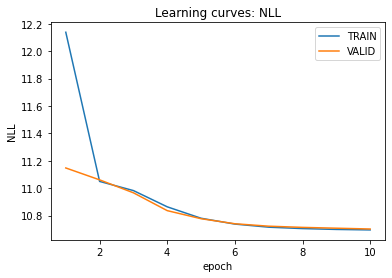

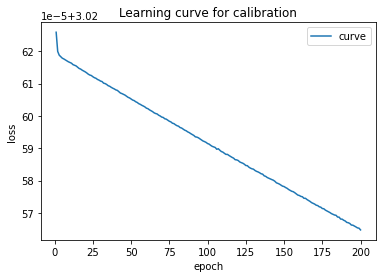

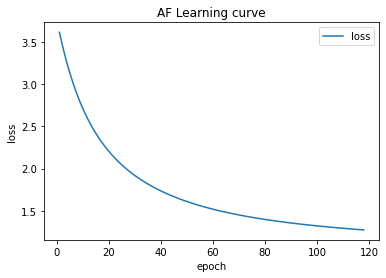

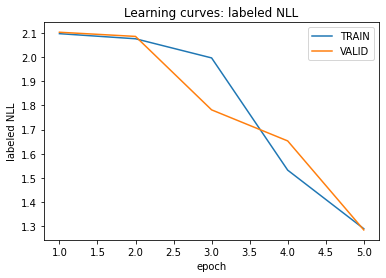

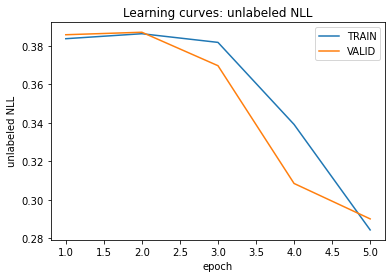

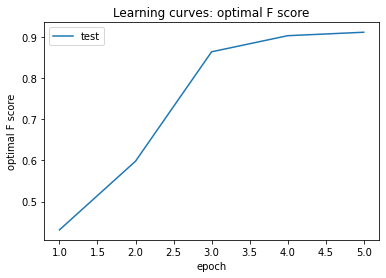

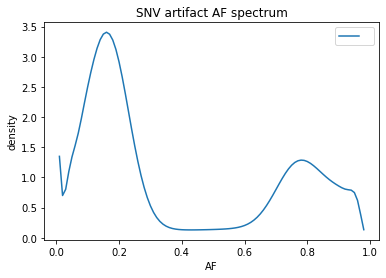

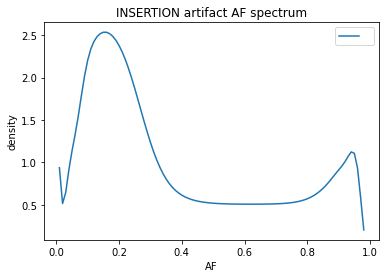

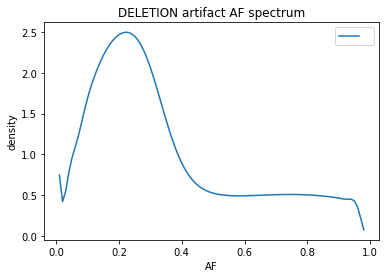

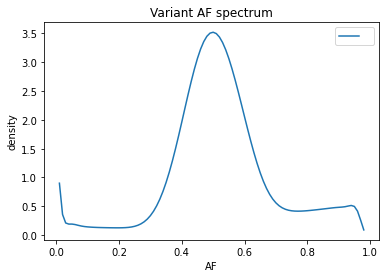

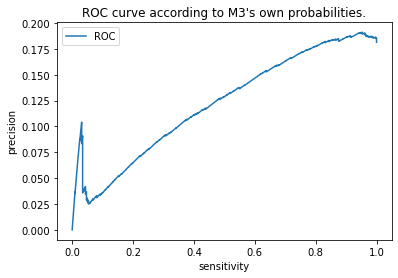

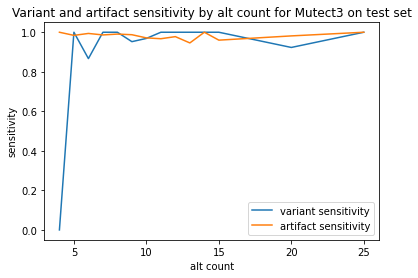

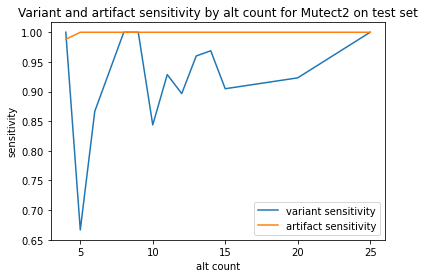

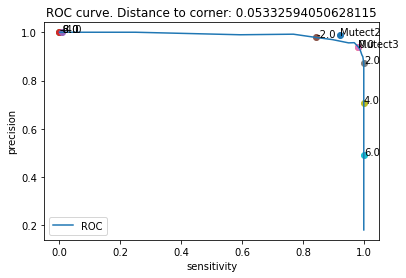

In [3]:
beta1 = Beta(5,1)
beta2 = Beta(5,1)
batch_size = 64
num_epochs = 5
params = train.TrainingParameters(batch_size, num_epochs, beta1, beta2)

hidden_read_layers = [20,20]
hidden_info_layers = [20,20]
aggregation_layers = [20]
output_layers = [10]
dropout_p = 0.2
m3_params = networks.Mutect3Parameters(hidden_read_layers, hidden_info_layers, aggregation_layers, output_layers, dropout_p)

trained_model = train.run_evaluation([DREAM_1_SMALL_PAIR], DREAM_1_SMALL_TEST, NA_PICKLE, params, m3_params)

In [5]:
training_pickles, test_pickle = [DREAM_1_SMALL_PAIR], DREAM_1_SMALL_TEST
train, valid, test = data.make_datasets(training_pickles, test_pickle)

Unlabeled data: 4423, labeled data: 8084
Dataset sizes -- training: 11256, validation: 1251, test: 1764


In [13]:
test[1].normal_depth() - test[1].normal_alt_count(), len(test[1].ref_tensor())

(108, 10)

Loading normal artifact dataset from pickled files
Training normal artifact model



Loading datasets from pickled files
Unlabeled data: 44457, labeled data: 80619
Dataset sizes -- training: 112568, validation: 12508, test: 17649
Training data includes 18 PASS variants labelled as artifacts.



Optimal logit threshold: 0.08844363689422607


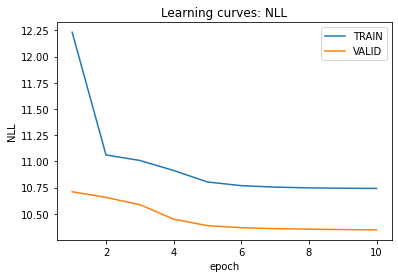

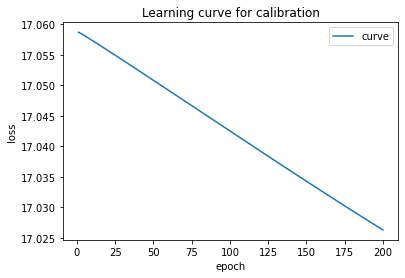

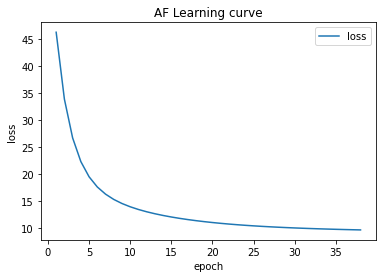

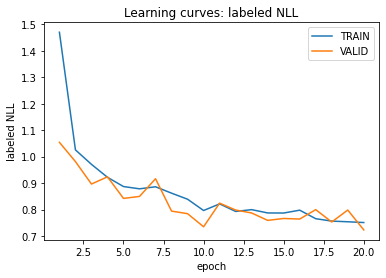

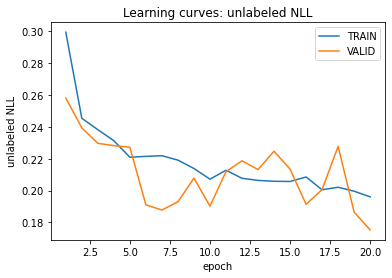

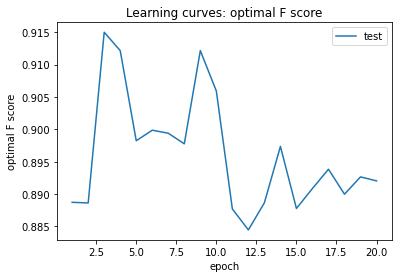

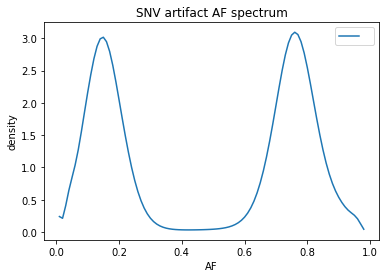

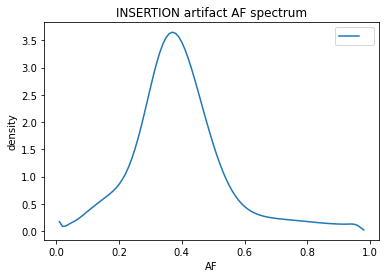

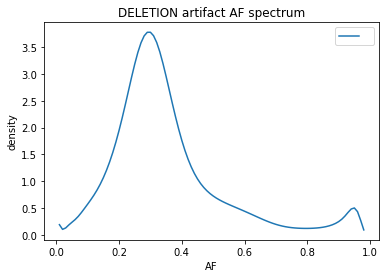

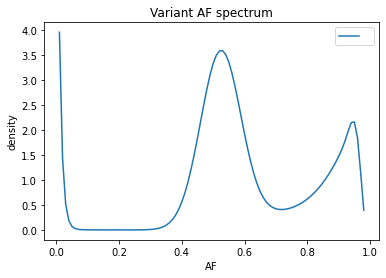

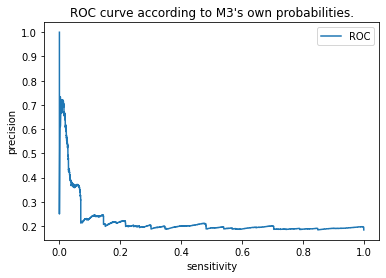

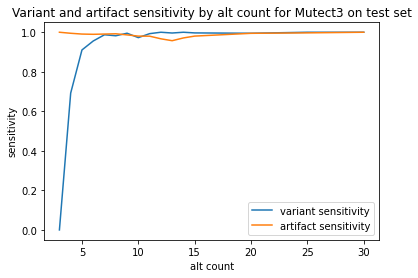

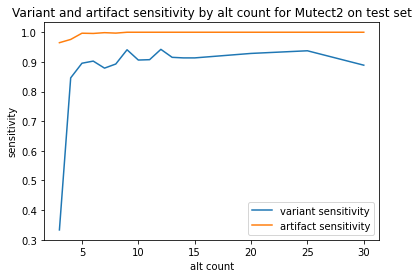

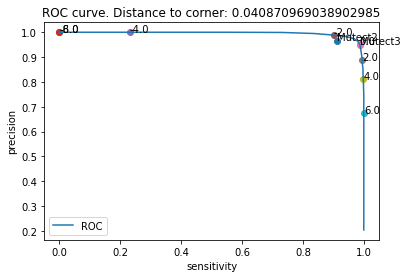

In [3]:
beta1 = Beta(5,1)
beta2 = Beta(5,1)
batch_size = 64
num_epochs = 20
params = train.TrainingParameters(batch_size, num_epochs, beta1, beta2)

hidden_read_layers = [30,30,30,30]
hidden_info_layers = [20,20,20]
aggregation_layers = [20,20]
output_layers = [10]
dropout_p = 0.2
m3_params = networks.Mutect3Parameters(hidden_read_layers, hidden_info_layers, aggregation_layers, output_layers, dropout_p)
trained_model = train.run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, NA_PICKLE, params, m3_params)

In [16]:
alpha, beta = na_model.get_beta_parameters(batch)
shapes = torch.stack((alpha, beta), dim=1)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9e53da3be0>)

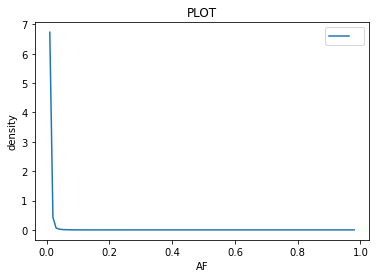

In [15]:
datum = na.NormalArtifactDatum(normal_alt_count=0, normal_depth=50, tumor_alt_count=10, tumor_depth=20, downsampling=1.0, variant_type="SNV")
na_model.plot_spectrum(datum, "PLOT")

In [41]:
snv_normal_af = []
snv_tumor_af = []
indel_normal_af = []
indel_tumor_af = []
for datum in na_train:
    if datum.variant_type() == "SNV":
        snv_normal_af.append(datum.normal_alt_count()/(datum.normal_depth()+0.01))
        snv_tumor_af.append(datum.tumor_alt_count()/(datum.tumor_depth()+0.01))
    else:
        indel_normal_af.append(datum.normal_alt_count()/(datum.normal_depth()+0.01))
        indel_tumor_af.append(datum.tumor_alt_count()/(datum.tumor_depth()+0.01))

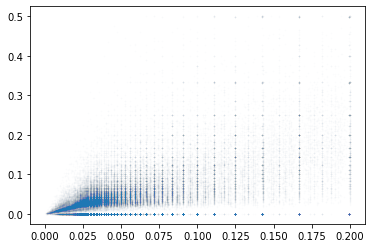

In [42]:
import matplotlib.pyplot as plt
plt.scatter(torch.tensor(snv_normal_af), torch.tensor(snv_tumor_af), s=0.5,alpha=0.01)

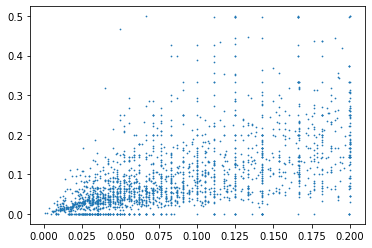

In [43]:
plt.scatter(torch.tensor(indel_normal_af), torch.tensor(indel_tumor_af), s=0.5,alpha=1.0)

ValueError: only one element tensors can be converted to Python scalars

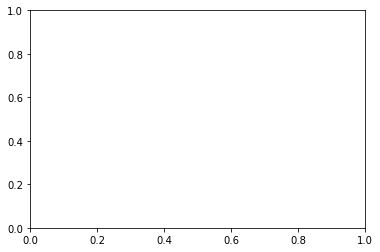

In [37]:
x=torch.tensor(normal_af)
y=torch.tensor(tumor_af)
plt.hist2d(x, y)